# Result Analysis

1. Regulated V.S. Unregulated

2. NSE distribution by Basin Size

3. NSE distribution by Land Use

## 0. Load Libraries and Data


In [1]:
import pandas as pd

# Define file paths (adjust if necessary)
attributes_file = "csv_files/attributes_with_mean.csv"
results_file = "results/EALSTM_temporal_result_filtered.csv"

# 1. Load the CSV files with selected columns
try:
    attributes_cols = ["gauge_id", "basin_category", "area", "dor_pc_pva"]
    df_attributes = pd.read_csv(attributes_file, usecols=attributes_cols)

    results_cols = ["basin_id", "NSE", "Performance"]
    df_results = pd.read_csv(results_file, usecols=results_cols)

    # 2. Merge the two DataFrames
    # Ensure the merge columns are of compatible types if necessary (e.g., both strings)
    # df_attributes['gauge_id'] = df_attributes['gauge_id'].astype(str)
    # df_results['basin_id'] = df_results['basin_id'].astype(str)

    merged_df = pd.merge(df_attributes, df_results, left_on="gauge_id", right_on="basin_id", how="inner")

    # Drop the redundant 'gauge_id' column
    merged_df = merged_df.drop(columns=["gauge_id"])

    # Display the first few rows of the merged DataFrame
    print("Merged DataFrame head:")
    print(merged_df.head())

    # Display basic info about the merged DataFrame
    print("\nMerged DataFrame Info:")
    merged_df.info()

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the file paths are correct.")
except KeyError as e:
    print(f"Error: Column {e} not found in one of the CSV files. Please check column names.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


boxplot_style = {
    "boxprops": {'facecolor':'none', 'edgecolor':'black'},
    "medianprops": {'color':'black'},
    "whiskerprops": {'color':'black'},
    "capprops": {'color':'black'},
    "flierprops": {'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'none', 'markersize': 15}
}

Merged DataFrame head:
   dor_pc_pva         area basin_category basin_id  NSE Performance
0         124  1569.087134             UD  02AA001  NaN         NaN
1           0   391.288236             UD  02AA002  NaN         NaN
2           0  3553.916861             UD  02AB001  NaN         NaN
3           0  2894.015833             UD  02AB002  NaN         NaN
4           0  3397.408320             UD  02AB004  NaN         NaN

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dor_pc_pva      960 non-null    int64  
 1   area            960 non-null    float64
 2   basin_category  960 non-null    object 
 3   basin_id        960 non-null    object 
 4   NSE             632 non-null    float64
 5   Performance     632 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 45.1+ KB


In [32]:
df_results.describe()

,NSE
count,632.000000
mean,0.528899
std,1.941023
min,-46.461361
25%,0.547301
50%,0.690514
75%,0.769388
max,0.897667


In [33]:
df_results['Performance'].value_counts(dropna=False)

Performance
Good              362
NaN               328
Excellent         204
Unsatisfactory     51
Negative           15
Name: count, dtype: int64

## Temporal Model Performance


| Statistic | NSE (old)   | NSE (new)   |
|-----------|-------------|-------------|
| count     | 647.000000  | 647.000000  |
| mean      | -           | -0.012294   |
| std       | -           | 11.037452   |
| min       | -           | -274.497576 |
| 25%       | 0.480       | 0.530759    |
| 50%       | 0.640       | 0.684652    |
| 75%       | 0.745       | 0.768132    |
| max       | 0.888       | 0.897667    |

**Performance Summary (based on NSE):**

| Performance      | Count (old) | Count (new)|
|------------------|-------|-------|
| Good             | 382   | 362   |
| N/A              | 328   | 328   |
| Excellent        | 2   | 204   |
| Unsatisfactory   | 70    | 51    |
| Negative         | 45    | 30    |

## Spatial Model Performance

| Statistic | NSE   (old) | NSE   (new) |
|-----------|-------------|-------------|
| count     | 168.000000  | 168.000000  |
| mean      | -           | -0.020477   |
| std       | -           | 3.944019    |
| min       | -           | -47.937880  |
| 25%       | -0.481      | 0.310496    |
| 50%       | 0.392       | 0.569357    |
| 75%       | 0.599       | 0.714350    |
| max       | 0.818       | 0.853896    |

**Performance Summary (based on NSE):**

| Performance      | Count (Old) | Count (New) |
|------------------|-------------|-------------|
| Good             | 80          | 91          |
| Excellent        | 7           | 28          |
| Unsatisfactory   | 27          | 28          |
| N/A              | 27          | 27          |
| Negative         | 54          | 21          |


## 1. Regulated V.S. Unregulated

- Regulated: `dor_pc_pva` > 0
- Unregulated: `dor_pc_pva` = 0

In [3]:

import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure merged_df is loaded and available from the previous cell
# Handle potential NaN values in NSE and dor_pc_pva before analysis
analysis_df = merged_df.dropna(subset=['NSE', 'dor_pc_pva']).copy()

# --- 1. Mann-Whitney U Test: Regulated vs Unregulated ---

print("--- 1. Mann-Whitney U Test: Regulated vs Unregulated ---")

# Create groups
regulated = analysis_df[analysis_df['dor_pc_pva'] > 100]['NSE']
unregulated = analysis_df[analysis_df['dor_pc_pva'] <= 100]['NSE']

# Perform the test
u_statistic, p_value_mw = stats.mannwhitneyu(regulated, unregulated, alternative='two-sided')

# Calculate descriptive statistics
desc_regulated = regulated.describe()
desc_unregulated = unregulated.describe()

# Create a results table
mw_results = pd.DataFrame({
    'Group': ['Regulated', 'Unregulated'],
    'N': [desc_regulated['count'], desc_unregulated['count']],
    'Mean NSE': [desc_regulated['mean'], desc_unregulated['mean']],
    'Median NSE': [desc_regulated['50%'], desc_unregulated['50%']],
    '25% Quartile': [desc_regulated['25%'], desc_unregulated['25%']],
    '75% Quartile': [desc_regulated['75%'], desc_unregulated['75%']]
})

boxplot_style = {
    "boxprops": {'facecolor':'none', 'edgecolor':'black'},
    "medianprops": {'color':'black'},
    "whiskerprops": {'color':'black'},
    "capprops": {'color':'black'},
    "flierprops": {'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'none', 'markersize': 5}
}

print(mw_results.to_string(index=False))
print(f"\nMann-Whitney U Statistic: {u_statistic:.4f}")
print(f"P-value: {p_value_mw:.4f}")
if p_value_mw < 0.05:
    print("Result: Significant difference between regulated and unregulated groups (p < 0.05).")
else:
    print("Result: No significant difference between regulated and unregulated groups (p >= 0.05).")
print("-" * 50)


--- 1. Mann-Whitney U Test: Regulated vs Unregulated ---
      Group     N  Mean NSE  Median NSE  25% Quartile  75% Quartile
  Regulated  67.0  0.604240    0.676014      0.541397      0.773393
Unregulated 565.0  0.519965    0.690538      0.547328      0.768559

Mann-Whitney U Statistic: 18854.0000
P-value: 0.9588
Result: No significant difference between regulated and unregulated groups (p >= 0.05).
--------------------------------------------------


In [4]:
# Try dropping the lowest 1 percent nse values (to omit extreme outliers)

import numpy as np
from scipy import stats
import pandas as pd

# Remove the lowest 1% NSE values before analysis
nse_1pct = merged_df['NSE'].quantile(0.01)
filtered_df = merged_df[merged_df['NSE'] >= nse_1pct].dropna(subset=['NSE', 'dor_pc_pva']).copy()

print(f"Lowest 1% NSE threshold: {nse_1pct:.4f}")
print(f"Number of samples after filtering: {len(filtered_df)}")

# --- Mann-Whitney U Test: Regulated vs Unregulated (after filtering) ---

regulated = filtered_df[filtered_df['dor_pc_pva'] > 100]['NSE']
unregulated = filtered_df[filtered_df['dor_pc_pva'] <= 100]['NSE']

u_statistic, p_value_mw = stats.mannwhitneyu(regulated, unregulated, alternative='two-sided')

desc_regulated = regulated.describe()
desc_unregulated = unregulated.describe()

mw_results = pd.DataFrame({
    'Group': ['Regulated', 'Unregulated'],
    'N': [desc_regulated['count'], desc_unregulated['count']],
    'Mean NSE': [desc_regulated['mean'], desc_unregulated['mean']],
    'Median NSE': [desc_regulated['50%'], desc_unregulated['50%']],
    '25% Quartile': [desc_regulated['25%'], desc_unregulated['25%']],
    '75% Quartile': [desc_regulated['75%'], desc_unregulated['75%']]
})

print("\n--- Mann-Whitney U Test (Lowest 1% NSE Removed) ---")
print(mw_results.to_string(index=False))
print(f"\nMann-Whitney U Statistic: {u_statistic:.4f}")
print(f"P-value: {p_value_mw:.4f}")
if p_value_mw < 0.05:
    print("Result: Significant difference between regulated and unregulated groups (p < 0.05).")
else:
    print("Result: No significant difference between regulated and unregulated groups (p >= 0.05).")
print("-" * 50)

Lowest 1% NSE threshold: -0.4818
Number of samples after filtering: 625

--- Mann-Whitney U Test (Lowest 1% NSE Removed) ---
      Group     N  Mean NSE  Median NSE  25% Quartile  75% Quartile
  Regulated  66.0  0.622895    0.687575      0.553076      0.773636
Unregulated 559.0  0.635271    0.691578      0.555075      0.769443

Mann-Whitney U Statistic: 18453.0000
P-value: 0.9968
Result: No significant difference between regulated and unregulated groups (p >= 0.05).
--------------------------------------------------


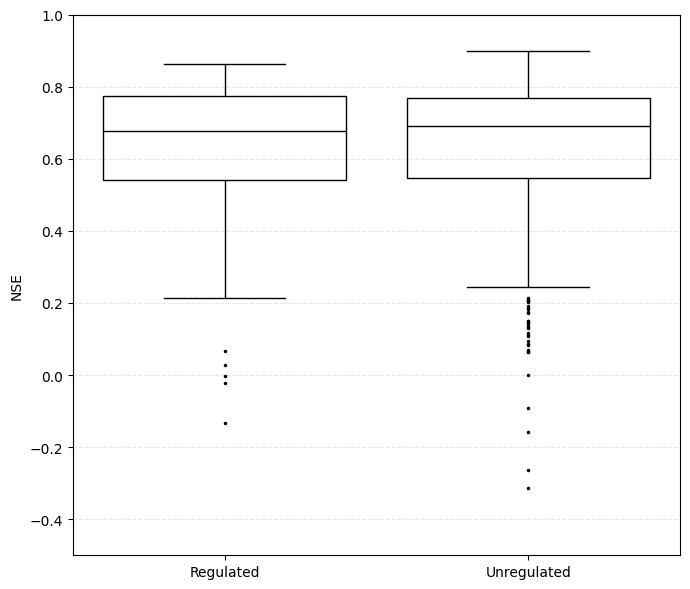

In [5]:
# Boxplot: NSE for Regulated vs Unregulated

# Combine data for plotting
plot_df = analysis_df.copy()
plot_df['Regulation'] = np.where(plot_df['dor_pc_pva'] > 100, 'Regulated', 'Unregulated')

# Set y-axis limits (adjust as needed)
ymin, ymax = -0.5, 1.0  # Change these values to filter out extreme values

plt.figure(figsize=(7, 6))
sns.boxplot(x='Regulation', y='NSE', data=plot_df, order=['Regulated', 'Unregulated'], **boxplot_style)
# plt.title('NSE Distribution: Regulated vs Unregulated')
plt.xlabel('')
plt.ylabel('NSE')
plt.ylim((ymin, ymax))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 2 NSE distribution by Basin Size 

The basins are divided into 5 groups based on their size.
The area bins are divided so that each bin contains the same number of basins.

- Bin 1: 4.8 km² - 71.9 km²
- Bin 2: 72.9 km² - 194.7 km²
- Bin 3: 195.7 km² - 472.4 km²
- Bin 4: 475.2 km² - 1,336.6 km²
- Bin 5: 1,341.5 km² - 16,387.6 km²


--- 2. ANOVA by Area (5 Quantile Bins) ---

Area Bins created based on quantiles:
                  min           max  count
area_bin                                  
Bin 1        4.848310     72.894505    127
Bin 2       73.809155    195.668890    126
Bin 3      195.858099    472.395888    126
Bin 4      475.172976   1331.446114    126
Bin 5     1336.495823  16387.626962    127

ANOVA Results (NSE by Area Bin):
                  sum_sq     df         F    PR(>F)
C(area_bin)     9.440371    4.0  0.624933  0.644862
Residual     2367.897349  627.0       NaN       NaN

ANOVA result is not significant (p >= 0.05). No post-hoc test needed.
--------------------------------------------------


C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\3204597315.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_ranges = area_anova_df.groupby('area_bin')['area'].agg(['min', 'max', 'count'])
C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\3204597315.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova_area = anova_table_area['PR(>F)'][0]
C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\3204597315.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels) # Set the custom labels


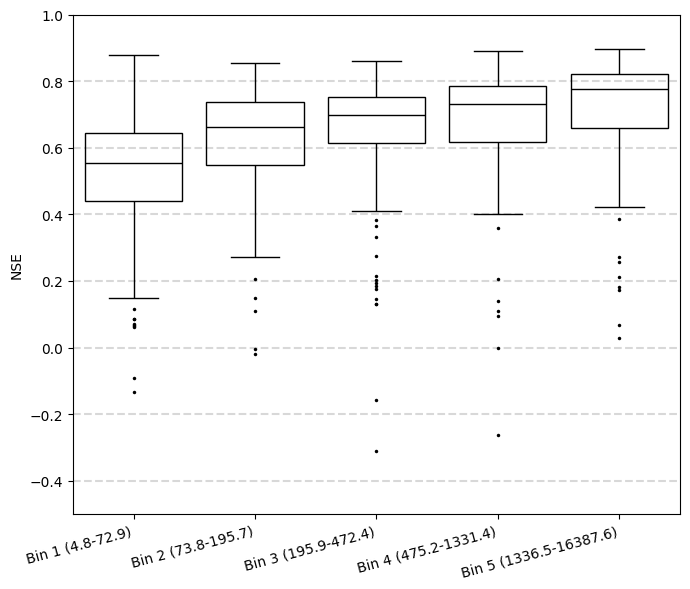

In [6]:
# In a new code cell

# --- 2a. ANOVA by Area (5 Quantile Bins) ---

print("\n--- 2. ANOVA by Area (5 Quantile Bins) ---")

# Ensure no NaNs in relevant columns for this analysis
area_anova_df = merged_df.dropna(subset=['NSE', 'area']).copy()

# Create 5 quantile bins for Area
# Using duplicates='drop' in case quantiles fall on the same area value
try:
    area_anova_df['area_bin'] = pd.qcut(area_anova_df['area'], q=5, labels=[f'Bin {i+1}' for i in range(5)], duplicates='drop')
    n_bins = area_anova_df['area_bin'].nunique()
    if n_bins < 5:
        print(f"Warning: Could only create {n_bins} bins due to duplicate area values at quantiles.")
        # Relabel if necessary
        area_anova_df['area_bin'] = pd.qcut(area_anova_df['area'], q=n_bins, labels=[f'Bin {i+1}' for i in range(n_bins)], duplicates='drop')


    print("\nArea Bins created based on quantiles:")
    # Store bin ranges
    bin_ranges = area_anova_df.groupby('area_bin')['area'].agg(['min', 'max', 'count'])
    print(bin_ranges)

    # Perform ANOVA
    model_area = ols('NSE ~ C(area_bin)', data=area_anova_df).fit()
    anova_table_area = sm.stats.anova_lm(model_area, typ=2)

    print("\nANOVA Results (NSE by Area Bin):")
    print(anova_table_area)

    # Check for significance
    p_value_anova_area = anova_table_area['PR(>F)'][0]
    if p_value_anova_area < 0.05:
        print("\nANOVA result is significant (p < 0.05). Performing Tukey's HSD test.")
        # Perform Tukey's HSD test
        tukey_area = pairwise_tukeyhsd(endog=area_anova_df['NSE'],
                                       groups=area_anova_df['area_bin'],
                                       alpha=0.05)
        print("\nTukey's HSD Post-Hoc Test Results:")
        print(tukey_area)
    else:
        print("\nANOVA result is not significant (p >= 0.05). No post-hoc test needed.")

except ValueError as e:
    print(f"\nError creating bins or performing ANOVA: {e}")
    print("This might happen if there are too few unique area values or insufficient data.")

print("-" * 50)

# Optional: Boxplot visualization
plt.figure(figsize=(7, 6)) # Adjusted figure size for longer labels
# Add horizontal lines
for y in np.arange(-0.4, 1.2, 0.2):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

# Create custom labels for x-axis
# Ensure bin_ranges exists and matches the bins plotted
if 'bin_ranges' in locals() and len(bin_ranges) == area_anova_df['area_bin'].nunique():
    x_labels = [f"{idx} ({row['min']:.1f}-{row['max']:.1f})" for idx, row in bin_ranges.iterrows()]
else:
    # Fallback if bin_ranges calculation failed or doesn't match
    x_labels = sorted(area_anova_df['area_bin'].unique())


ax = sns.boxplot(x='area_bin', y='NSE', data=area_anova_df, order=sorted(area_anova_df['area_bin'].unique()), **boxplot_style) # Ensure order matches labels
ax.set_xticklabels(x_labels) # Set the custom labels

plt.ylim((-0.5, 1))
# plt.title('NSE Distribution by Area Quantile Bins')
plt.xlabel('') # Updated label description
plt.ylabel('NSE')
plt.xticks(rotation=15, ha='right') # Slightly rotate if labels overlap
plt.tight_layout() # Adjust layout


plt.show()

In [7]:
# --- Table of summary statistics for each area bin ---
print("\nSummary statistics for each area bin (for LaTeX or markdown table):")
summary_table = []
for idx, row in bin_ranges.iterrows():
    bin_df = area_anova_df[area_anova_df['area_bin'] == idx]
    count = len(bin_df)
    mean_nse = bin_df['NSE'].mean()
    median_nse = bin_df['NSE'].median()
    q25 = bin_df['NSE'].quantile(0.25)
    q75 = bin_df['NSE'].quantile(0.75)
    # Format: Bin label & count & mean & median & 25% & 75%
    summary_table.append((str(idx), count, mean_nse, median_nse, q25, q75))

# Print header
print("Bin & Count & Mean NSE & Median NSE & 25% & 75% \\\\")
for i, (label, count, mean_nse, median_nse, q25, q75) in enumerate(summary_table):
    # Use special labels for first and last bin
    if i == 0:
        bin_label = "Smallest area bin"
    elif i == len(summary_table) - 1:
        bin_label = "Largest area bin"
    else:
        bin_label = f"Bin {i+1}"
    print(f"{bin_label} & {count} & {mean_nse:.3f} & {median_nse:.3f} & {q25:.3f} & {q75:.3f} \\\\")


Summary statistics for each area bin (for LaTeX or markdown table):
Bin & Count & Mean NSE & Median NSE & 25% & 75% \\
Smallest area bin & 127 & 0.493 & 0.554 & 0.441 & 0.645 \\
Bin 2 & 126 & 0.617 & 0.661 & 0.547 & 0.737 \\
Bin 3 & 126 & 0.550 & 0.697 & 0.615 & 0.753 \\
Bin 4 & 126 & 0.670 & 0.731 & 0.617 & 0.786 \\
Largest area bin & 127 & 0.317 & 0.776 & 0.660 & 0.821 \\



--- 3. ANOVA by Area (Using Bins from Step 2, Lowest 1% NSE Removed) ---

Removing NSE values below the 1st percentile: -0.4818
Number of samples after removing low NSE values: 625

Counts per original Area Bin after filtering low NSE values:
area_bin
Bin 1    124
Bin 2    126
Bin 3    125
Bin 4    126
Bin 5    124
Name: count, dtype: int64

ANOVA Results (NSE by Original Area Bin, Filtered Data):
                sum_sq     df          F        PR(>F)
C(area_bin)   2.595323    4.0  18.717569  1.541151e-14
Residual     21.491844  620.0        NaN           NaN

ANOVA result is significant (p < 0.05). Performing Tukey's HSD test.

Tukey's HSD Post-Hoc Test Results (Filtered Data, Original Bins):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Bin 1  Bin 2   0.0927 0.0009  0.0282 0.1571   True
 Bin 1  Bin 3   0.1163    0.0  0.0517 0.1808   True
 Bin 1  Bin 4   0.1465    0.0   0.08

C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\3122729435.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_plot_labels)


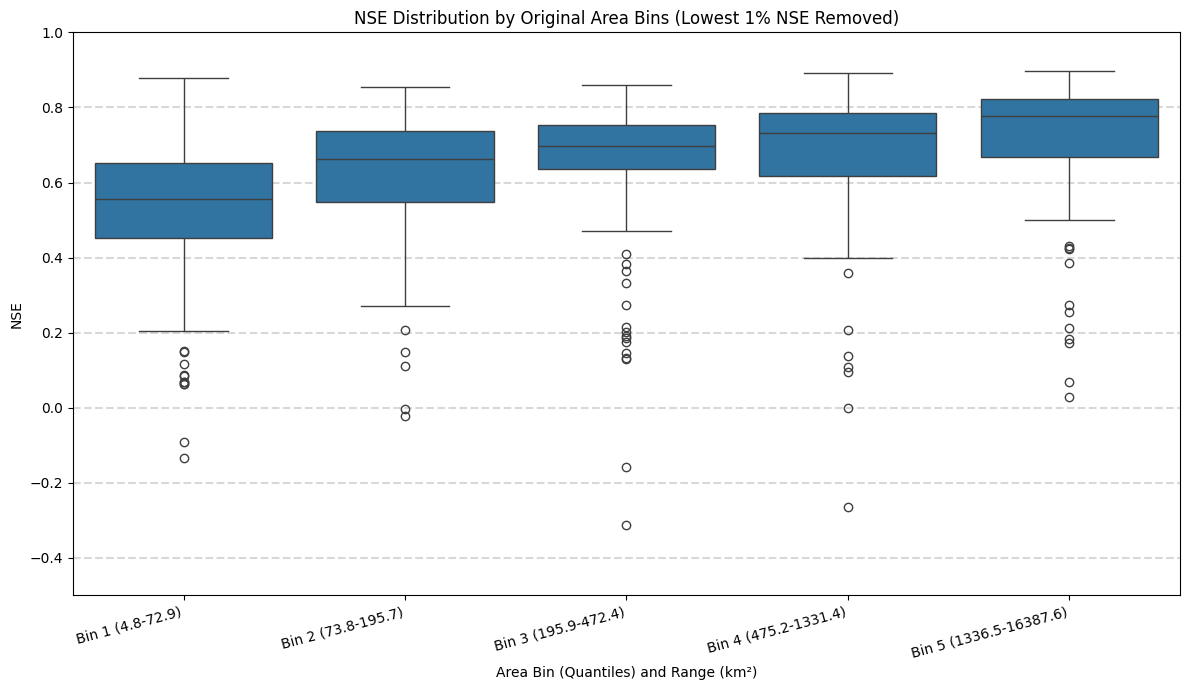

In [8]:
# In a new code cell

# --- 2b. ANOVA by Area (Using Bins from Step 2, Lowest 1% NSE Removed) ---

print("\n--- 3. ANOVA by Area (Using Bins from Step 2, Lowest 1% NSE Removed) ---")

# Ensure no NaNs in relevant columns
# Start with the original dataframe used for binning in step 2
area_anova_filtered_df = area_anova_df.copy() # Use the df from step 2 which already has area_bin

# Calculate the 1st percentile of NSE from this dataframe (before filtering but after dropping initial NaNs)
nse_percentile_1 = area_anova_filtered_df['NSE'].quantile(0.01)
print(f"\nRemoving NSE values below the 1st percentile: {nse_percentile_1:.4f}")

# Filter the DataFrame based on NSE percentile
area_anova_filtered_df = area_anova_filtered_df[area_anova_filtered_df['NSE'] >= nse_percentile_1].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Number of samples after removing low NSE values: {len(area_anova_filtered_df)}")

# The 'area_bin' column from step 2 is already present in area_anova_filtered_df
# Verify counts per bin after filtering
print("\nCounts per original Area Bin after filtering low NSE values:")
print(area_anova_filtered_df['area_bin'].value_counts().sort_index()) # Sort index to match bin order

# Check if any bins became empty after filtering
if area_anova_filtered_df['area_bin'].nunique() < n_bins: # n_bins from step 2
     print(f"Warning: After filtering, only {area_anova_filtered_df['area_bin'].nunique()} bins have data.")

# Perform ANOVA on the filtered data using the original bins
try:
    # Ensure there's enough data in at least two bins to perform ANOVA
    if area_anova_filtered_df['area_bin'].nunique() >= 2:
        model_area_filtered = ols('NSE ~ C(area_bin)', data=area_anova_filtered_df).fit()
        anova_table_area_filtered = sm.stats.anova_lm(model_area_filtered, typ=2)

        print("\nANOVA Results (NSE by Original Area Bin, Filtered Data):")
        print(anova_table_area_filtered)

        # Check for significance
        # Note: Index might be different if a bin became empty, access p-value carefully
        p_value_anova_area_filtered = anova_table_area_filtered.loc['C(area_bin)', 'PR(>F)'] # Access by index name

        if p_value_anova_area_filtered < 0.05:
            print("\nANOVA result is significant (p < 0.05). Performing Tukey's HSD test.")
            # Perform Tukey's HSD test
            tukey_area_filtered = pairwise_tukeyhsd(endog=area_anova_filtered_df['NSE'],
                                                    groups=area_anova_filtered_df['area_bin'], # Use the original bin assignment
                                                    alpha=0.05)
            print("\nTukey's HSD Post-Hoc Test Results (Filtered Data, Original Bins):")
            print(tukey_area_filtered)
        else:
            print("\nANOVA result is not significant (p >= 0.05). No post-hoc test needed.")
    else:
        print("\nSkipping ANOVA: Not enough bins with data after filtering.")

except Exception as e: # Catch potential errors during ANOVA/Tukey
    print(f"\nError performing ANOVA or Tukey's HSD on filtered data: {e}")

print("-" * 50)

# Optional: Boxplot visualization using original bins and filtered data
plt.figure(figsize=(12, 7)) # Adjusted figure size
# Add horizontal lines
for y in np.arange(-0.4, 1.2, 0.2):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

# Use the same x_labels created in step 2
# Ensure bin_ranges and x_labels from step 2 are available
if 'bin_ranges' in locals() and 'x_labels' in locals() and len(bin_ranges) == n_bins:
     # Ensure the order matches the unique bins present in the filtered data for plotting
    plot_order = sorted(area_anova_filtered_df['area_bin'].unique())
    # Filter x_labels to only include those bins present in plot_order
    filtered_x_labels = [lbl for lbl in x_labels if any(f"Bin {i+1}" in lbl for i, b in enumerate(plot_order) if f"Bin {i+1}" == b)]

    ax = sns.boxplot(x='area_bin', y='NSE', data=area_anova_filtered_df, order=plot_order)
    # Set the filtered labels corresponding to the plot_order
    # This assumes x_labels were created like "Bin 1 (min-max)", "Bin 2 (min-max)", etc.
    label_map = {f"Bin {i+1}": lbl for i, lbl in enumerate(x_labels)}
    final_plot_labels = [label_map[bin_name] for bin_name in plot_order]
    ax.set_xticklabels(final_plot_labels)

else:
    # Fallback if labels from step 2 aren't available
    print("Warning: Bin range labels from step 2 not found. Using default bin names.")
    ax = sns.boxplot(x='area_bin', y='NSE', data=area_anova_filtered_df, order=sorted(area_anova_filtered_df['area_bin'].unique()))


plt.ylim((-0.5, 1)) # Keep consistent y-axis limits if desired
plt.title('NSE Distribution by Original Area Bins (Lowest 1% NSE Removed)')
plt.xlabel('Area Bin (Quantiles) and Range (km²)') # Use the descriptive label
plt.ylabel('NSE')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 3. NSE distribution by Land Use


--- 4. ANOVA by Basin Category ---

Basin Categories and Counts:
basin_category
MX    221
UD    219
AG    135
UR     57
Name: count, dtype: int64

ANOVA Results (NSE by Basin Category):
                        sum_sq     df         F    PR(>F)
C(basin_category)     7.065446    3.0  0.623993  0.599676
Residual           2370.272274  628.0       NaN       NaN

ANOVA result is not significant (p >= 0.05). No post-hoc test needed.
--------------------------------------------------


C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\1262895870.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova_category = anova_table_category['PR(>F)'][0]


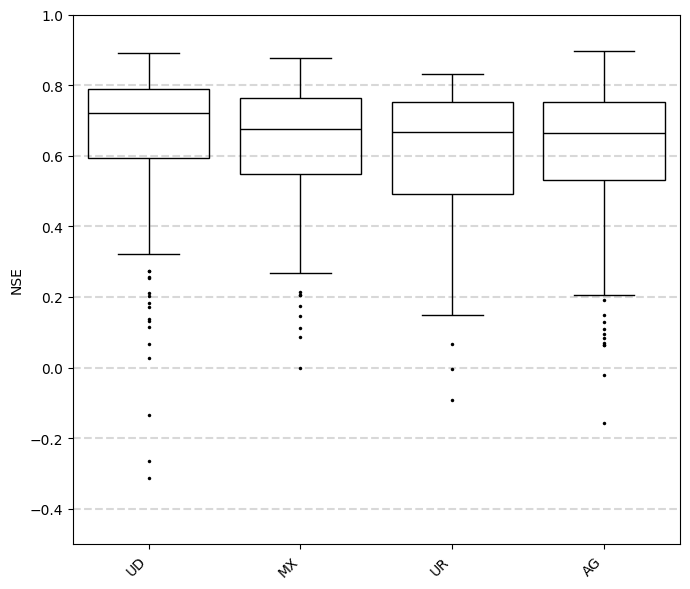

In [9]:
# In a new code cell

# --- 3. ANOVA by Basin Category ---

print("\n--- 4. ANOVA by Basin Category ---")

# Ensure no NaNs in relevant columns
category_anova_df = merged_df.dropna(subset=['NSE', 'basin_category']).copy()

print("\nBasin Categories and Counts:")
print(category_anova_df['basin_category'].value_counts())

# Perform ANOVA
# Using C() to explicitly treat 'basin_category' as categorical
model_category = ols('NSE ~ C(basin_category)', data=category_anova_df).fit()
anova_table_category = sm.stats.anova_lm(model_category, typ=2)

print("\nANOVA Results (NSE by Basin Category):")
print(anova_table_category)

# Check for significance
p_value_anova_category = anova_table_category['PR(>F)'][0]
if p_value_anova_category < 0.05:
    print("\nANOVA result is significant (p < 0.05). Performing Tukey's HSD test.")
    # Perform Tukey's HSD test
    tukey_category = pairwise_tukeyhsd(endog=category_anova_df['NSE'],
                                       groups=category_anova_df['basin_category'],
                                       alpha=0.05)
    print("\nTukey's HSD Post-Hoc Test Results:")
    print(tukey_category)
else:
    print("\nANOVA result is not significant (p >= 0.05). No post-hoc test needed.")

print("-" * 50)

# Optional: Boxplot visualization
plt.figure(figsize=(7, 6))
for y in np.arange(-0.4, 1.2, 0.2):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

sns.boxplot(x='basin_category', y='NSE', data=category_anova_df, **boxplot_style)
plt.ylim((-0.5, 1))
# plt.title('NSE Distribution by Basin Category')
plt.xlabel('')
plt.ylabel('NSE')
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.tight_layout()
plt.show()


--- 4. ANOVA by Basin Category ---

Basin Categories and Counts:
basin_category
MX    221
UD    219
AG    135
UR     57
Name: count, dtype: int64

ANOVA Results (NSE by Basin Category):
                        sum_sq     df         F    PR(>F)
C(basin_category)     7.065446    3.0  0.623993  0.599676
Residual           2370.272274  628.0       NaN       NaN

ANOVA result is not significant (p >= 0.05). No post-hoc test needed.
--------------------------------------------------

Summary statistics for each basin category (for LaTeX or markdown table):
Category & Count & Mean NSE & Median NSE & 25% & 75% \\
Undeveloped (UD) & 219 & 0.385 & 0.721 & 0.594 & 0.790 \\
Urban (UR) & 57 & 0.572 & 0.666 & 0.492 & 0.751 \\
Mixed-use (MX) & 221 & 0.617 & 0.675 & 0.547 & 0.763 \\
Agricultural (AG) & 135 & 0.600 & 0.665 & 0.532 & 0.752 \\


C:\Users\ybrot\AppData\Local\Temp\ipykernel_222508\3538560584.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova_category = anova_table_category['PR(>F)'][0]


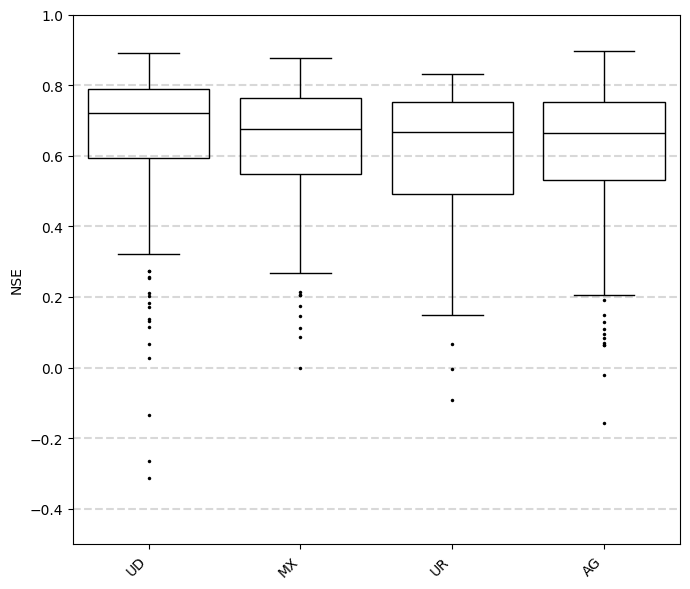

In [12]:
print("\n--- 4. ANOVA by Basin Category ---")

# Ensure no NaNs in relevant columns
category_anova_df = merged_df.dropna(subset=['NSE', 'basin_category']).copy()

print("\nBasin Categories and Counts:")
print(category_anova_df['basin_category'].value_counts())

# Perform ANOVA
# Using C() to explicitly treat 'basin_category' as categorical
model_category = ols('NSE ~ C(basin_category)', data=category_anova_df).fit()
anova_table_category = sm.stats.anova_lm(model_category, typ=2)

print("\nANOVA Results (NSE by Basin Category):")
print(anova_table_category)

# Check for significance
p_value_anova_category = anova_table_category['PR(>F)'][0]
if p_value_anova_category < 0.05:
    print("\nANOVA result is significant (p < 0.05). Performing Tukey's HSD test.")
    # Perform Tukey's HSD test
    tukey_category = pairwise_tukeyhsd(endog=category_anova_df['NSE'],
                                       groups=category_anova_df['basin_category'],
                                       alpha=0.05)
    print("\nTukey's HSD Post-Hoc Test Results:")
    print(tukey_category)
else:
    print("\nANOVA result is not significant (p >= 0.05). No post-hoc test needed.")

print("-" * 50)

# --- Table of summary statistics for each basin category ---
print("\nSummary statistics for each basin category (for LaTeX or markdown table):")
summary_table = []
for cat in category_anova_df['basin_category'].unique():
    cat_df = category_anova_df[category_anova_df['basin_category'] == cat]
    count = len(cat_df)
    mean_nse = cat_df['NSE'].mean()
    median_nse = cat_df['NSE'].median()
    q25 = cat_df['NSE'].quantile(0.25)
    q75 = cat_df['NSE'].quantile(0.75)
    summary_table.append((cat, count, mean_nse, median_nse, q25, q75))

# Print header
print("Category & Count & Mean NSE & Median NSE & 25% & 75% \\\\")
# Print in preferred order if you want
cat_order = ['UD', 'UR', 'MX', 'AG']
cat_labels = {
    'UD': 'Undeveloped (UD)',
    'UR': 'Urban (UR)',
    'MX': 'Mixed-use (MX)',
    'AG': 'Agricultural (AG)'
}
for cat in cat_order:
    row = next((r for r in summary_table if r[0] == cat), None)
    if row:
        label, count, mean_nse, median_nse, q25, q75 = row
        print(f"{cat_labels[cat]} & {count} & {mean_nse:.3f} & {median_nse:.3f} & {q25:.3f} & {q75:.3f} \\\\")

# Optional: Boxplot visualization
plt.figure(figsize=(7, 6))
for y in np.arange(-0.4, 1.2, 0.2):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

sns.boxplot(x='basin_category', y='NSE', data=category_anova_df, **boxplot_style)
plt.ylim((-0.5, 1))
plt.xlabel('')
plt.ylabel('NSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
import random

# --- Select random small headwater basin and urban basin ---

# Small basin group = Bin 1 (smallest drainage area)
if 'area_anova_df' in locals() and 'area_bin' in area_anova_df.columns:
    small_group = area_anova_df[area_anova_df['area_bin'] == "Bin 1"]
else:
    raise ValueError("Area bins not found. Run the area ANOVA section first.")

# Urban basin group = category code "UR"
if 'category_anova_df' in locals() and 'basin_category' in category_anova_df.columns:
    urban_group = category_anova_df[category_anova_df['basin_category'] == "UR"]
else:
    raise ValueError("Basin categories not found. Run the basin type ANOVA section first.")

# Random selection
if not small_group.empty:
    small_basin_id = random.choice(small_group['basin_id'].tolist())
    print(f"Randomly chosen small basin: {small_basin_id}")
else:
    print("No small basin found!")

if not urban_group.empty:
    urban_basin_id = random.choice(urban_group['basin_id'].tolist())
    print(f"Randomly chosen urban basin: {urban_basin_id}")
else:
    print("No urban basin found!")



Randomly chosen small basin: 04164100
Randomly chosen urban basin: 04201500


In [23]:
import random
import pandas as pd

# --- Find basin IDs that are in Bin 5 and UD ---

if 'area_anova_df' in locals() and 'category_anova_df' in locals():
    if 'area_bin' in area_anova_df.columns and 'basin_category' in category_anova_df.columns:
        # Select only relevant columns before merging
        area_df = area_anova_df[['basin_id', 'area_bin']]
        category_df = category_anova_df[['basin_id', 'basin_category']]

        # Merge
        merged_df = pd.merge(area_df, category_df, on='basin_id', how='inner')

        # Apply filters
        target_group = merged_df[
            (merged_df['area_bin'] == "Bin 5") &
            (merged_df['basin_category'] == "UD")
        ]

        # Randomly select one if available
        if not target_group.empty:
            chosen_basin_id = random.choice(target_group['basin_id'].tolist())
            print(f"Randomly chosen basin (Bin 5 & UD): {chosen_basin_id}")
        else:
            print("No basin found matching Bin 5 and UD criteria.")
    else:
        raise ValueError("Missing required columns in DataFrames.")
else:
    raise ValueError("Required DataFrames not found. Run ANOVA sections first.")


Randomly chosen basin (Bin 5 & UD): 04228500


In [17]:
if 'area_anova_df' in locals() and 'category_anova_df' in locals():
    print("ANOVA dataframes found. Selecting random basins for case studies...")
    
    # 1. Select random small headwater basin
    small_group = area_anova_df[area_anova_df['area_bin'] == "Bin 1"]
    if not small_group.empty:
        small_headwater_id = random.choice(small_group['basin_id'].tolist())

    # 2. Select random urban basin
    urban_group = category_anova_df[category_anova_df['basin_category'] == "UR"]
    if not urban_group.empty:
        urban_basin_id = random.choice(urban_group['basin_id'].tolist())

    # 3. Find and select a large, undeveloped basin
    merged_df = pd.merge(area_anova_df, category_anova_df, on="basin_id")
    large_ud_group = merged_df[
        (merged_df['area_bin'] == "Bin 5") & 
        (merged_df['basin_category'] == "UD")
    ]
    if not large_ud_group.empty:
        large_undeveloped_id = random.choice(large_ud_group['basin_id'].tolist())
    
    print(f"Selected Small Basin: {small_headwater_id}")
    print(f"Selected Urban Basin: {urban_basin_id}")
    print(f"Selected Large, Undeveloped Basin: {large_undeveloped_id}")

ANOVA dataframes found. Selecting random basins for case studies...


KeyError: 'basin_category'


--- 4. ANOVA by Basin Category (Lowest 1% NSE Removed) ---
Lowest 1% NSE threshold: -0.4818
Number of samples after filtering: 625

Basin Categories and Counts (after filtering):
basin_category
MX    218
UD    216
AG    134
UR     57
Name: count, dtype: int64

ANOVA Results (NSE by Basin Category, Lowest 1% NSE Removed):
                      sum_sq     df        F    PR(>F)
C(basin_category)   0.409190    3.0  3.57726  0.013786
Residual           23.677977  621.0      NaN       NaN

ANOVA result is significant (p < 0.05). Performing Tukey's HSD test.


C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2879646408.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova_category = anova_table_category['PR(>F)'][0]



Tukey's HSD Post-Hoc Test Results (Lowest 1% NSE Removed):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AG     MX   0.0278 0.5655 -0.0274   0.083  False
    AG     UD   0.0454 0.1498 -0.0099  0.1007  False
    AG     UR    -0.04 0.5667 -0.1195  0.0396  False
    MX     UD   0.0176 0.7841 -0.0307  0.0659  False
    MX     UR  -0.0678 0.0918 -0.1426  0.0071  False
    UD     UR  -0.0854 0.0181 -0.1603 -0.0105   True
----------------------------------------------------
--------------------------------------------------


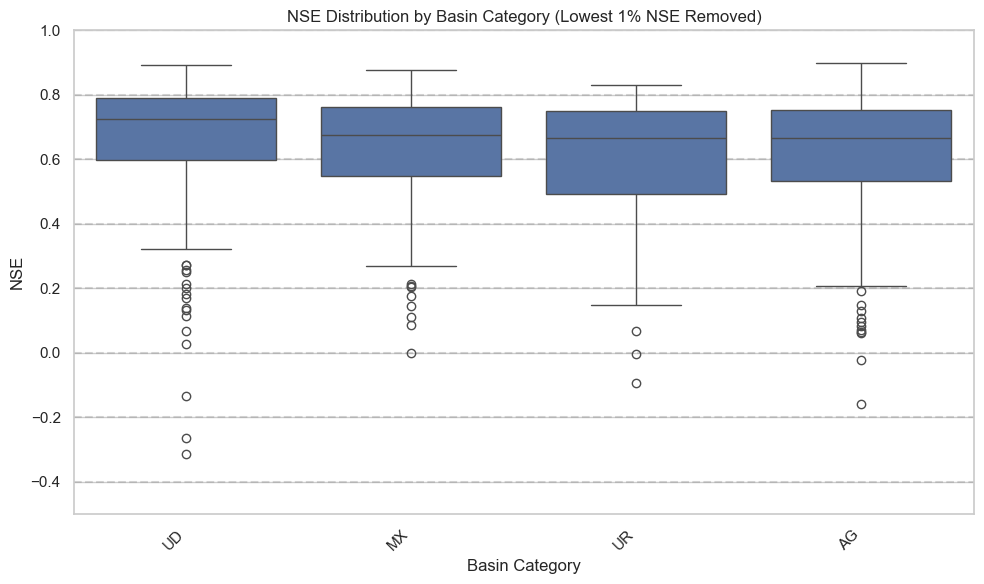

In [42]:
# In a new code cell

# --- 3. ANOVA by Basin Category (Lowest 1% NSE Removed) ---

print("\n--- 4. ANOVA by Basin Category (Lowest 1% NSE Removed) ---")

# Remove the lowest 1% NSE values
nse_1pct = merged_df['NSE'].quantile(0.01)
filtered_category_df = merged_df[merged_df['NSE'] >= nse_1pct].dropna(subset=['NSE', 'basin_category']).copy()

print(f"Lowest 1% NSE threshold: {nse_1pct:.4f}")
print(f"Number of samples after filtering: {len(filtered_category_df)}")

print("\nBasin Categories and Counts (after filtering):")
print(filtered_category_df['basin_category'].value_counts())

# Perform ANOVA
model_category = ols('NSE ~ C(basin_category)', data=filtered_category_df).fit()
anova_table_category = sm.stats.anova_lm(model_category, typ=2)

print("\nANOVA Results (NSE by Basin Category, Lowest 1% NSE Removed):")
print(anova_table_category)

# Check for significance
p_value_anova_category = anova_table_category['PR(>F)'][0]
if p_value_anova_category < 0.05:
    print("\nANOVA result is significant (p < 0.05). Performing Tukey's HSD test.")
    tukey_category = pairwise_tukeyhsd(
        endog=filtered_category_df['NSE'],
        groups=filtered_category_df['basin_category'],
        alpha=0.05
    )
    print("\nTukey's HSD Post-Hoc Test Results (Lowest 1% NSE Removed):")
    print(tukey_category)
else:
    print("\nANOVA result is not significant (p >= 0.05). No post-hoc test needed.")

print("-" * 50)

# Optional: Boxplot visualization
plt.figure(figsize=(10, 6))
for y in np.arange(-0.4, 1.2, 0.2):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

sns.boxplot(x='basin_category', y='NSE', data=filtered_category_df)
plt.ylim((-0.5, 1))
plt.title('NSE Distribution by Basin Category (Lowest 1% NSE Removed)')
plt.xlabel('Basin Category')
plt.ylabel('NSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_ranges = area_df.groupby('area_bin')['area'].agg(['min', 'max'])
C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(area_x_labels, rotation=45, ha='right')
C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


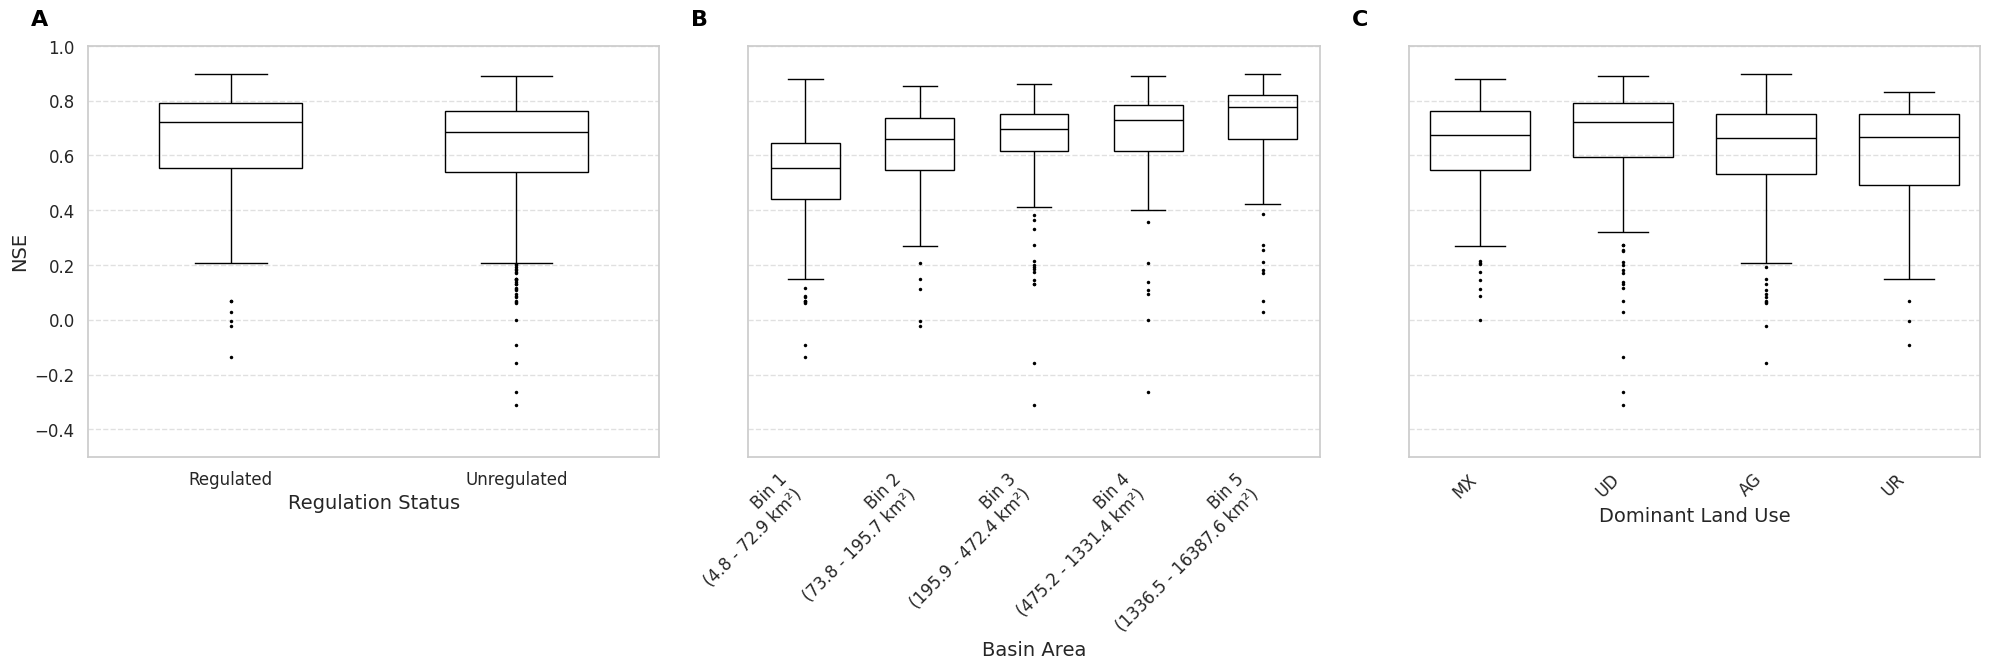

C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_ranges = area_df.groupby('area_bin')['area'].agg(['min', 'max'])
C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(area_x_labels, rotation=45, ha='right')
C:\Users\ybrot\AppData\Local\Temp\ipykernel_697860\2430209146.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


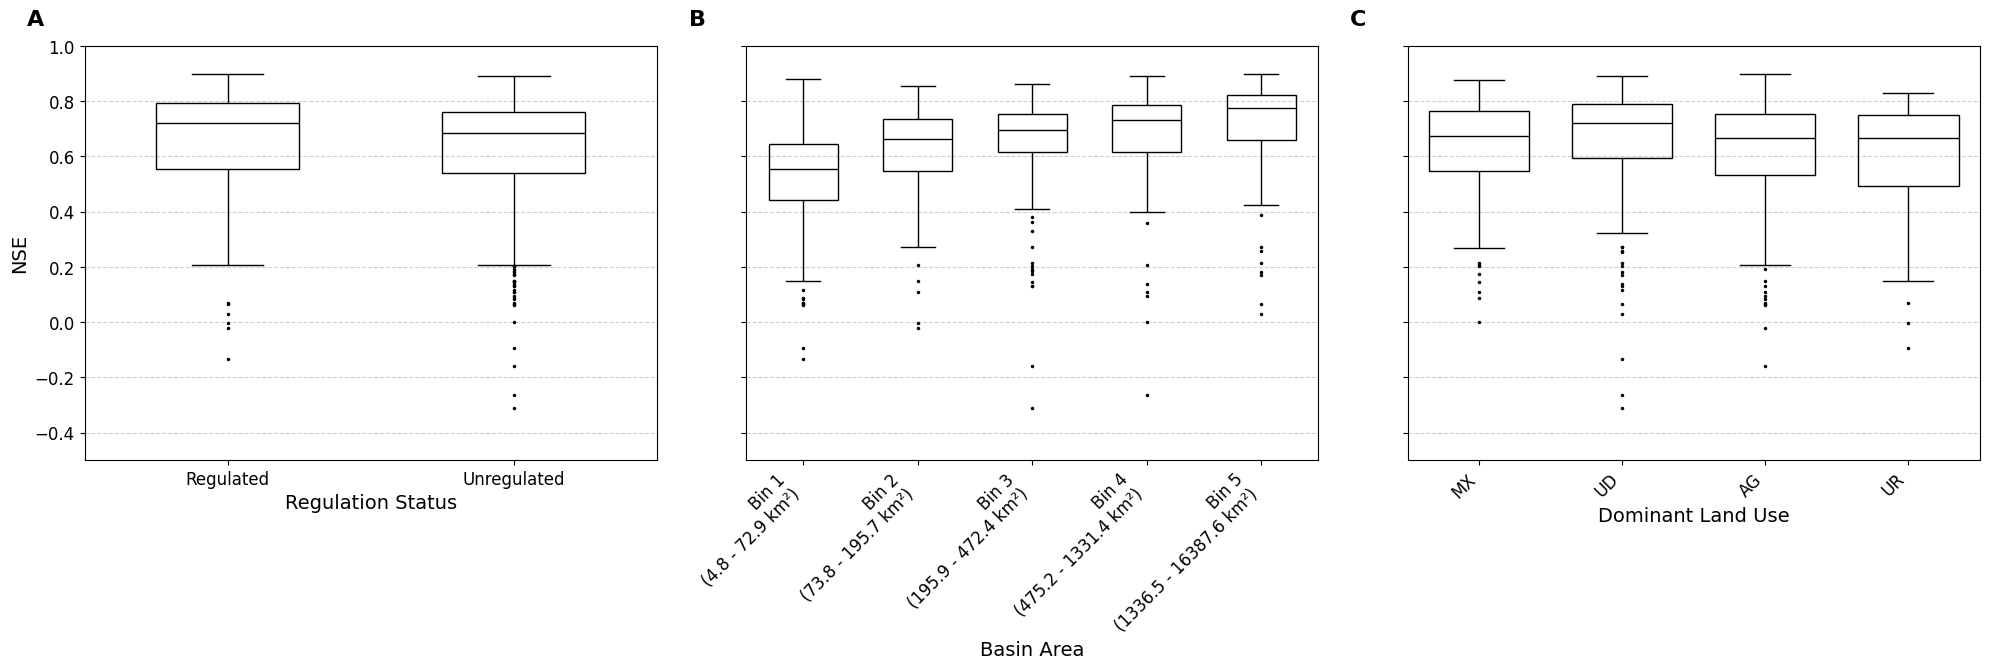

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Data Preparation (assuming 'merged_df' is already loaded) ---

# 1. Data for Regulation plot
reg_df = merged_df.dropna(subset=['NSE', 'dor_pc_pva']).copy()
reg_df['Regulation'] = np.where(reg_df['dor_pc_pva'] > 0, 'Regulated', 'Unregulated')

# 2. Data for Area plot
area_df = merged_df.dropna(subset=['NSE', 'area']).copy()
try:
    area_df['area_bin'] = pd.qcut(area_df['area'], q=5, labels=[f'Bin {i+1}' for i in range(5)], duplicates='drop')
    bin_ranges = area_df.groupby('area_bin')['area'].agg(['min', 'max'])
    area_x_labels = [f"{idx}\n({row['min']:.1f} - {row['max']:.1f} km²)" for idx, row in bin_ranges.iterrows()]
except Exception:
    # Fallback if binning fails
    area_df['area_bin'] = 'N/A'
    area_x_labels = ['N/A']


# 3. Data for Category plot
category_df = merged_df.dropna(subset=['NSE', 'basin_category']).copy()


# --- Plotting ---

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
plt.style.use('default') # Use a standard style as a base

# Define professional styling for the boxplots
boxplot_style = {
    "boxprops": {'facecolor':'none', 'edgecolor':'black'},
    "medianprops": {'color':'black'},
    "whiskerprops": {'color':'black'},
    "capprops": {'color':'black'},
    "flierprops": {'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'none', 'markersize': 5}
}
font_size = 14
y_limits = (-0.5, 1.0)

# --- Subplot A: Regulated vs Unregulated ---
sns.boxplot(ax=axes[0], x='Regulation', y='NSE', data=reg_df, order=['Regulated', 'Unregulated'], width=0.5, **boxplot_style)
axes[0].set_xlabel('Regulation Status', fontsize=font_size)
axes[0].set_ylabel('NSE', fontsize=font_size)
axes[0].set_ylim(y_limits)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, size=font_size+2, weight='bold')


# --- Subplot B: NSE by Area Bins ---
plot_order_area = sorted(area_df['area_bin'].unique())
sns.boxplot(ax=axes[1], x='area_bin', y='NSE', data=area_df, order=plot_order_area, width=0.6, **boxplot_style)
axes[1].set_xlabel('Basin Area', fontsize=font_size)
axes[1].set_ylabel('') # No y-label for middle plot
axes[1].set_ylim(y_limits)
axes[1].set_xticklabels(area_x_labels, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[1].tick_params(axis='y', labelleft=False) # Hide y-tick labels
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, size=font_size+2, weight='bold')


# --- Subplot C: NSE by Basin Category ---
plot_order_cat = category_df['basin_category'].value_counts().index # Order by count
sns.boxplot(ax=axes[2], x='basin_category', y='NSE', data=category_df, order=plot_order_cat, width=0.7, **boxplot_style)
axes[2].set_xlabel('Dominant Land Use', fontsize=font_size)
axes[2].set_ylabel('') # No y-label for last plot
axes[2].set_ylim(y_limits)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].grid(axis='y', linestyle='--', alpha=0.6)
axes[2].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[2].tick_params(axis='y', labelleft=False) # Hide y-tick labels
axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes, size=font_size+2, weight='bold')


# Final adjustments and display
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle if needed
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Data Preparation (assuming 'merged_df' is already loaded) ---

# 1. Data for Regulation plot
reg_df = merged_df.dropna(subset=['NSE', 'dor_pc_pva']).copy()
reg_df['Regulation'] = np.where(reg_df['dor_pc_pva'] > 0, 'Regulated', 'Unregulated')

# 2. Data for Area plot
area_df = merged_df.dropna(subset=['NSE', 'area']).copy()
try:
    area_df['area_bin'] = pd.qcut(area_df['area'], q=5, labels=[f'Bin {i+1}' for i in range(5)], duplicates='drop')
    bin_ranges = area_df.groupby('area_bin')['area'].agg(['min', 'max'])
    area_x_labels = [f"{idx}\n({row['min']:.1f} - {row['max']:.1f} km²)" for idx, row in bin_ranges.iterrows()]
except Exception:
    # Fallback if binning fails
    area_df['area_bin'] = 'N/A'
    area_x_labels = ['N/A']


# 3. Data for Category plot
category_df = merged_df.dropna(subset=['NSE', 'basin_category']).copy()


# --- Plotting ---

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
plt.style.use('default') # Use a standard style as a base

# Define professional styling for the boxplots
boxplot_style = {
    "boxprops": {'facecolor':'none', 'edgecolor':'black'},
    "medianprops": {'color':'black'},
    "whiskerprops": {'color':'black'},
    "capprops": {'color':'black'},
    "flierprops": {'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'none', 'markersize': 5}
}
font_size = 14
y_limits = (-0.5, 1.0)

# --- Subplot A: Regulated vs Unregulated ---
sns.boxplot(ax=axes[0], x='Regulation', y='NSE', data=reg_df, order=['Regulated', 'Unregulated'], width=0.5, **boxplot_style)
axes[0].set_xlabel('Regulation Status', fontsize=font_size)
axes[0].set_ylabel('NSE', fontsize=font_size)
axes[0].set_ylim(y_limits)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, size=font_size+2, weight='bold')


# --- Subplot B: NSE by Area Bins ---
plot_order_area = sorted(area_df['area_bin'].unique())
sns.boxplot(ax=axes[1], x='area_bin', y='NSE', data=area_df, order=plot_order_area, width=0.6, **boxplot_style)
axes[1].set_xlabel('Basin Area', fontsize=font_size)
axes[1].set_ylabel('') # No y-label for middle plot
axes[1].set_ylim(y_limits)
axes[1].set_xticklabels(area_x_labels, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[1].tick_params(axis='y', labelleft=False) # Hide y-tick labels
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, size=font_size+2, weight='bold')


# --- Subplot C: NSE by Basin Category ---
plot_order_cat = category_df['basin_category'].value_counts().index # Order by count
sns.boxplot(ax=axes[2], x='basin_category', y='NSE', data=category_df, order=plot_order_cat, width=0.7, **boxplot_style)
axes[2].set_xlabel('Dominant Land Use', fontsize=font_size)
axes[2].set_ylabel('') # No y-label for last plot
axes[2].set_ylim(y_limits)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].grid(axis='y', linestyle='--', alpha=0.6)
axes[2].tick_params(axis='both', which='major', labelsize=font_size-2)
axes[2].tick_params(axis='y', labelleft=False) # Hide y-tick labels
axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes, size=font_size+2, weight='bold')


# Final adjustments and display
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle if needed
plt.show()

In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.patches import Rectangle

# 1. Paths to your data
can_shp = "../metadata/shapefile/ADP02_Basin_Select.shp"
us_shp  = "../metadata/shapefile/GL_GAGE2_all.shp"
csv_fp  = "./csv_files/result.csv"

# 2. Load & normalize the Canadian basins
can = gpd.read_file(can_shp).to_crs(epsg=3857)
can = can.rename(columns={"StationNum": "basin_id"})
can["basin_id"] = can["basin_id"].astype(str)
can["country"] = "Canada"

# 3. Load & normalize the US basins
us = gpd.read_file(us_shp).to_crs(epsg=3857)
us = us.rename(columns={"GAGE_ID": "basin_id"})
us["basin_id"] = us["basin_id"].astype(str)
us["country"] = "US"

# 4. Combine both GeoDataFrames
gdf = pd.concat([can, us], ignore_index=True)

# 5. Load your performance results
df = pd.read_csv(csv_fp, dtype={"basin_id": str})

# 6. Merge on basin_id and drop any with no label
gdf = gdf.merge(df, on="basin_id", how="left")
gdf = gdf[gdf["Performance"].notna()]

# 7. Compute centroids for plotting
gdf["x"] = gdf.geometry.centroid.x
gdf["y"] = gdf.geometry.centroid.y

# 8. Assign marker shapes: circle for Canada, triangle for US
gdf["marker"] = np.where(gdf["country"] == "Canada", "o", "^")

# 9. Define your light‐shade color map
color_map = {
    "Excellent":      "#40cd40",  # light green
    "Good":           "#23b2e1",  # light blue
    "Unsatisfactory": "gold",
    "Negative":       "red"
}
gdf["color"] = gdf["Performance"].map(color_map)

# 10. Begin plotting
fig, ax = plt.subplots(figsize=(12, 9))

for label, col in color_map.items():
    for mk in ["o", "^"]:
        subset = gdf[(gdf.Performance == label) & (gdf.marker == mk)]
        if subset.empty:
            continue
        ax.scatter(
            subset["x"], subset["y"],
            c=subset["color"],
            marker=mk,
            edgecolor="black",
            linewidth=1,
            s=60,
            alpha=0.7
        )

# 11. Add the CartoDB Positron basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# 12. Remove axes
ax.set_axis_off()

# 13. Build legend entries with rectangle swatches
counts = {
    lbl: {
        "Canada": int(((gdf.country == "Canada") & (gdf.Performance == lbl)).sum()),
        "US":      int(((gdf.country == "US")      & (gdf.Performance == lbl)).sum())
    }
    for lbl in color_map
}

legend_info = [
    (color_map["Excellent"], f"high accuracy (Canada={counts['Excellent']['Canada']}, US={counts['Excellent']['US']})"),
    (color_map["Good"],      f"moderate accuracy (Canada={counts['Good']['Canada']}, US={counts['Good']['US']})"),
    (color_map["Unsatisfactory"], f"low accuracy (Canada={counts['Unsatisfactory']['Canada']}, US={counts['Unsatisfactory']['US']})"),
    (color_map["Negative"],  f"Negative NSE (Canada={counts['Negative']['Canada']}, US={counts['Negative']['US']})"),
]

proxies = [
    Rectangle((0,0), 1, 0.5,
              facecolor=col,
              edgecolor="gray",
              linewidth=0.5)
    for col, _ in legend_info
]
labels = [lbl for _, lbl in legend_info]

ax.legend(
    proxies,
    labels,
    title="Performance",
    loc="upper right",
    frameon=True,
    handlelength=1.5,
    handleheight=0.8,
    fontsize=16,           # set legend font size
    title_fontsize=16      # set legend title font size
)

# 14. Finish
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './csv_files/result.csv'

## CDF to compare simulation performance

In [46]:
import pandas as pd

EALSTM_temporal_result = pd.read_csv("results/EALSTM_temporal_result.csv").dropna()
EALSTM_spatial_result = pd.read_csv("results/EALSTM_spatial_result.csv").dropna()
LSTM_temporal_result = pd.read_csv("results/LSTM_temporal_result.csv").dropna()
NWM_result = pd.read_csv("results/NWM_result.csv").dropna()

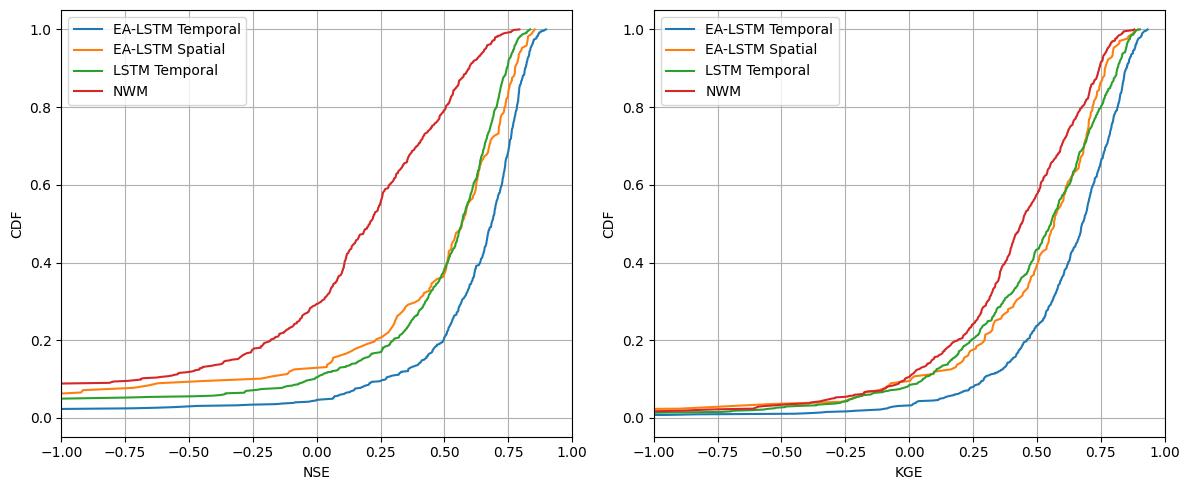

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Update these paths if your CSVs live elsewhere
datasets = {
    "EA-LSTM Temporal": pd.read_csv("results/EALSTM_temporal_result.csv"),
    "EA-LSTM Spatial": pd.read_csv("results/EALSTM_spatial_result.csv"),
    "LSTM Temporal": pd.read_csv("results/LSTM_temporal_result.csv"),
    "NWM": pd.read_csv("results/NWM_result.csv")
}

def empirical_cdf(series):
    """Compute empirical CDF for a pandas Series."""
    vals = np.sort(series.dropna().values)
    cdf = np.arange(1, len(vals) + 1) / len(vals)
    return vals, cdf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot CDF of NSE
for label, df in datasets.items():
    x, y = empirical_cdf(df["NSE"])
    ax1.plot(x, y, label=label)
# ax1.set_title("Empirical CDF of NSE")
ax1.set_xlabel("NSE")
ax1.set_ylabel("CDF")
ax1.set_xlim(-1, 1)
ax1.grid(True)
ax1.legend()

# Plot CDF of KGE
for label, df in datasets.items():
    x, y = empirical_cdf(df["KGE"])
    ax2.plot(x, y, label=label)
# ax2.set_title("Empirical CDF of KGE")
ax2.set_xlabel("KGE")
ax2.set_ylabel("CDF")
ax2.set_xlim(-1, 1)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


In [48]:
print("Median NSE")
for name, df in datasets.items():
    print(f"{name:16s}: {df['NSE'].median():.3f}")

print("\nMedian KGE")
for name, df in datasets.items():
    print(f"{name:16s}: {df['KGE'].median():.3f}")


Median NSE
EA-LSTM Temporal: 0.685
EA-LSTM Spatial : 0.569
LSTM Temporal   : 0.567
NWM             : 0.208

Median KGE
EA-LSTM Temporal: 0.678
EA-LSTM Spatial : 0.567
LSTM Temporal   : 0.555
NWM             : 0.440


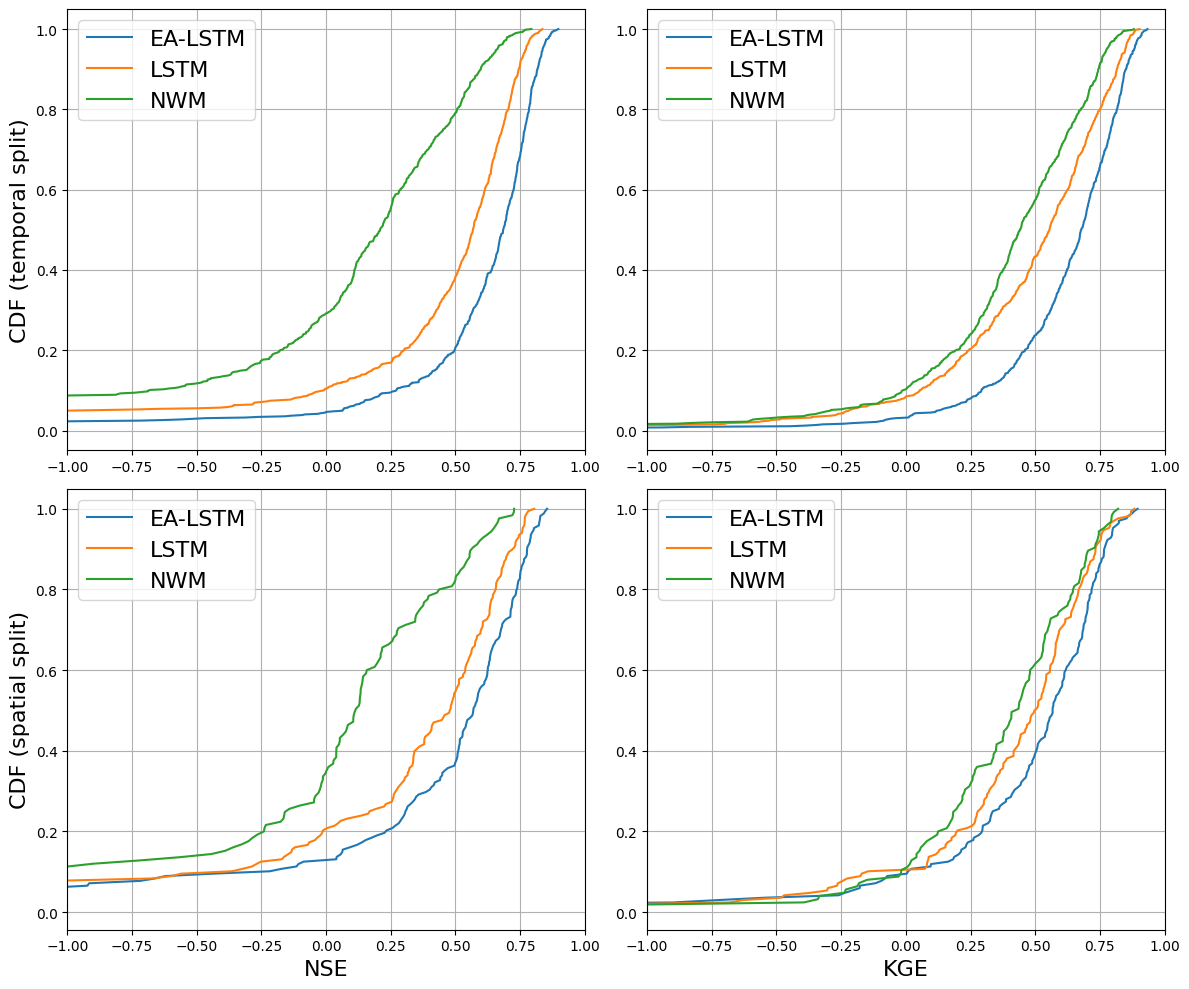

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Update these paths if your CSVs live elsewhere
datasets_temporal = {
    "EA-LSTM": pd.read_csv("results/EALSTM_temporal_result.csv"),
    "LSTM": pd.read_csv("results/lstm_temporal_result.csv"),
    "NWM": pd.read_csv("results/NWM_temporal_result.csv")
}

datasets_spatial = {
    "EA-LSTM": pd.read_csv("results/EALSTM_spatial_result.csv"),
    "LSTM": pd.read_csv("results/lstm_spatial_result.csv"),
    "NWM": pd.read_csv("results/NWM_spatial_result.csv")
}

def empirical_cdf(series):
    """Compute empirical CDF for a pandas Series."""
    vals = np.sort(series.dropna().values)
    cdf = np.arange(1, len(vals) + 1) / len(vals)
    return vals, cdf

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First row: temporal
for label, df in datasets_temporal.items():
    x_nse, y_nse = empirical_cdf(df["NSE"])
    axes[0, 0].plot(x_nse, y_nse, label=label)
    x_kge, y_kge = empirical_cdf(df["KGE"])
    axes[0, 1].plot(x_kge, y_kge, label=label)

axes[0, 0].set_title("")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("CDF (temporal split)", fontsize=16)
axes[0, 0].set_xlim(-1, 1)
axes[0, 0].grid(True)
axes[0, 0].legend()

axes[0, 1].set_title("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlim(-1, 1)
axes[0, 1].grid(True)
axes[0, 1].legend()

# Second row: spatial
for label, df in datasets_spatial.items():
    x_nse, y_nse = empirical_cdf(df["NSE"])
    axes[1, 0].plot(x_nse, y_nse, label=label)
    x_kge, y_kge = empirical_cdf(df["KGE"])
    axes[1, 1].plot(x_kge, y_kge, label=label)



axes[1, 0].set_title("")
axes[1, 0].set_xlabel("NSE", fontsize=16)
axes[1, 0].set_ylabel("CDF (spatial split)", fontsize=16)
axes[1, 0].set_xlim(-1, 1)
axes[1, 0].grid(True)
axes[1, 0].legend()

axes[1, 1].set_title("")
axes[1, 1].set_xlabel("KGE", fontsize=16)
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlim(-1, 1)
axes[1, 1].grid(True)
axes[1, 1].legend()

for ax in axes.flat:
    ax.legend(fontsize=16)

plt.tight_layout()
plt.show()


## NWM Model Evaluation

### Tested on temporal test set

In [50]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION ---
# Define the paths to your files and directories
SIMULATION_FILE = 'csv_files/GL_NWM3.csv'
OBSERVATION_DIR = '../metadata/csv_filtered'
BASIN_LIST_FILE = '../basin_list/complete_basin_list.txt' # Create this file with your basin IDs
OUTPUT_FILE = 'NWM_temporal_result.csv'

# Define the evaluation period
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'

# --- 2. HELPER FUNCTIONS ---

def calculate_nse(observed, simulated):
    """Calculates Nash-Sutcliffe Efficiency (NSE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan
    
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    if denominator == 0: # Avoid division by zero if observed flow is constant
        return -np.inf
        
    return 1 - (numerator / denominator)

def calculate_kge(observed, simulated):
    """Calculates Kling-Gupta Efficiency (KGE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan

    # Pearson correlation coefficient
    r = np.corrcoef(observed, simulated)[0, 1]
    if np.isnan(r): # Handle case where correlation is undefined
        return np.nan

    # Alpha (variability ratio)
    std_sim = np.std(simulated)
    std_obs = np.std(observed)
    if std_obs == 0:
        return -np.inf
    alpha = std_sim / std_obs

    # Beta (bias ratio)
    mean_sim = np.mean(simulated)
    mean_obs = np.mean(observed)
    if mean_obs == 0:
        return -np.inf
    beta = mean_sim / mean_obs
    
    # KGE calculation
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

def classify_performance(nse):
    """Classifies model performance based on NSE score."""
    if pd.isna(nse):
        return 'N/A'
    if nse > 0.75:
        return 'Excellent'
    if nse >= 0.36:
        return 'Good'
    if nse >= 0:
        return 'Unsatisfactory'
    return 'Negative'

# --- 3. DATA LOADING AND PREPARATION ---

# Load the list of basins to evaluate
try:
    with open(BASIN_LIST_FILE, 'r') as f:
        target_basin_ids = [line.strip() for line in f if line.strip()]
    print(f"Found {len(target_basin_ids)} basins to evaluate from '{BASIN_LIST_FILE}'.")
except FileNotFoundError:
    print(f"ERROR: Basin list file not found at '{BASIN_LIST_FILE}'. Please create it.")
    exit()

# Load and process the simulation data
print("Loading and processing simulation data...")
sim_df_raw = pd.read_csv(SIMULATION_FILE, low_memory=False)

# ** FIX: Normalize the 'gages' column to handle missing leading zeros **
# Convert to string, then pad with leading zeros to a length of 8 ONLY if the ID is numeric.
s = sim_df_raw['gages'].astype(str)
numeric_mask = s.str.isdigit()
s.loc[numeric_mask] = s.loc[numeric_mask].str.zfill(8)
sim_df_raw['gages'] = s
# ** END FIX **

# Filter for target basins before melting to save memory
sim_df_filtered = sim_df_raw[sim_df_raw['gages'].isin(target_basin_ids)].copy()

if sim_df_filtered.empty:
    print("ERROR: None of the target basins were found in the simulation file.")
    exit()

# Melt the dataframe from wide to long format
id_vars = [col for col in sim_df_filtered.columns if not col.isdigit()]
sim_df_long = pd.melt(sim_df_filtered, id_vars=id_vars, var_name='date_str', value_name='simulated_q')

# Convert date string to datetime objects
sim_df_long['date'] = pd.to_datetime(sim_df_long['date_str'], format='%Y%m%d')
sim_df_long = sim_df_long.rename(columns={'gages': 'basin_id'})

# Filter by date and select necessary columns
sim_df = sim_df_long[
    (sim_df_long['date'] >= START_DATE) & 
    (sim_df_long['date'] <= END_DATE)
][['basin_id', 'date', 'simulated_q']].set_index('basin_id')
print("Simulation data processing complete.")


# --- 4. METRIC CALCULATION ---

results = []
print(f"Calculating metrics for the period {START_DATE} to {END_DATE}...")

for basin_id in tqdm(target_basin_ids, desc="Evaluating Basins"):
    nse, kge = np.nan, np.nan # Default values

    # Check if basin exists in the processed simulation data
    if basin_id not in sim_df.index:
        # print(f"Warning: Basin {basin_id} not found in simulation file. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue

    # Load observed data
    obs_file_path = os.path.join(OBSERVATION_DIR, f"{basin_id}.csv")
    if not os.path.exists(obs_file_path):
        # print(f"Warning: Observation file for basin {basin_id} not found. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue
        
    obs_df = pd.read_csv(obs_file_path, usecols=['date', 'discharge'], parse_dates=['date'])
    obs_df = obs_df.rename(columns={'discharge': 'observed_q'})
    
    # Filter observed data for the evaluation period
    obs_df_period = obs_df[
        (obs_df['date'] >= START_DATE) & 
        (obs_df['date'] <= END_DATE)
    ].copy()

    # Get simulation data for the current basin
    sim_df_basin = sim_df.loc[[basin_id]].reset_index()

    # Merge observed and simulated data on date
    merged_df = pd.merge(obs_df_period, sim_df_basin, on='date', how='inner')
    
    # Drop rows where either observed or simulated is NaN
    merged_df.dropna(subset=['observed_q', 'simulated_q'], inplace=True)

    if not merged_df.empty:
        observed_values = merged_df['observed_q'].values
        simulated_values = merged_df['simulated_q'].values
        
        # Calculate metrics
        nse = calculate_nse(observed_values, simulated_values)
        kge = calculate_kge(observed_values, simulated_values)

    results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})

# --- 5. FINAL OUTPUT ---

# Create final DataFrame
results_df = pd.DataFrame(results)

# Add performance column
results_df['Performance'] = results_df['NSE'].apply(classify_performance)

# Save to CSV
results_df.to_csv(OUTPUT_FILE, index=False)

print(f"\nEvaluation complete. Results saved to '{OUTPUT_FILE}'.")
print("\nResults Summary:")
print(results_df.describe())
print("\nPerformance Counts:")
print(results_df['Performance'].value_counts())

Found 975 basins to evaluate from '../basin_list/complete_basin_list.txt'.
Loading and processing simulation data...


FileNotFoundError: [Errno 2] No such file or directory: 'csv_files/GL_NWM3.csv'

### Tested on spatial test set

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION ---
# Define the paths to your files and directories
SIMULATION_FILE = 'csv_files/GL_NWM3.csv'
OBSERVATION_DIR = '../metadata/csv_filtered'
BASIN_LIST_FILE = '../basin_list/regional_test.txt' # Create this file with your basin IDs
OUTPUT_FILE = 'NWM_spatial_result.csv'

# Define the evaluation period
START_DATE = '1980-01-01'
END_DATE = '2023-12-31'

# --- 2. HELPER FUNCTIONS ---

def calculate_nse(observed, simulated):
    """Calculates Nash-Sutcliffe Efficiency (NSE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan
    
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    if denominator == 0: # Avoid division by zero if observed flow is constant
        return -np.inf
        
    return 1 - (numerator / denominator)

def calculate_kge(observed, simulated):
    """Calculates Kling-Gupta Efficiency (KGE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan

    # Pearson correlation coefficient
    r = np.corrcoef(observed, simulated)[0, 1]
    if np.isnan(r): # Handle case where correlation is undefined
        return np.nan

    # Alpha (variability ratio)
    std_sim = np.std(simulated)
    std_obs = np.std(observed)
    if std_obs == 0:
        return -np.inf
    alpha = std_sim / std_obs

    # Beta (bias ratio)
    mean_sim = np.mean(simulated)
    mean_obs = np.mean(observed)
    if mean_obs == 0:
        return -np.inf
    beta = mean_sim / mean_obs
    
    # KGE calculation
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

def classify_performance(nse):
    """Classifies model performance based on NSE score."""
    if pd.isna(nse):
        return 'N/A'
    if nse > 0.75:
        return 'Excellent'
    if nse >= 0.36:
        return 'Good'
    if nse >= 0:
        return 'Unsatisfactory'
    return 'Negative'

# --- 3. DATA LOADING AND PREPARATION ---

# Load the list of basins to evaluate
try:
    with open(BASIN_LIST_FILE, 'r') as f:
        target_basin_ids = [line.strip() for line in f if line.strip()]
    print(f"Found {len(target_basin_ids)} basins to evaluate from '{BASIN_LIST_FILE}'.")
except FileNotFoundError:
    print(f"ERROR: Basin list file not found at '{BASIN_LIST_FILE}'. Please create it.")
    exit()

# Load and process the simulation data
print("Loading and processing simulation data...")
sim_df_raw = pd.read_csv(SIMULATION_FILE, low_memory=False)

# ** FIX: Normalize the 'gages' column to handle missing leading zeros **
# Convert to string, then pad with leading zeros to a length of 8 ONLY if the ID is numeric.
s = sim_df_raw['gages'].astype(str)
numeric_mask = s.str.isdigit()
s.loc[numeric_mask] = s.loc[numeric_mask].str.zfill(8)
sim_df_raw['gages'] = s
# ** END FIX **

# Filter for target basins before melting to save memory
sim_df_filtered = sim_df_raw[sim_df_raw['gages'].isin(target_basin_ids)].copy()

if sim_df_filtered.empty:
    print("ERROR: None of the target basins were found in the simulation file.")
    exit()

# Melt the dataframe from wide to long format
id_vars = [col for col in sim_df_filtered.columns if not col.isdigit()]
sim_df_long = pd.melt(sim_df_filtered, id_vars=id_vars, var_name='date_str', value_name='simulated_q')

# Convert date string to datetime objects
sim_df_long['date'] = pd.to_datetime(sim_df_long['date_str'], format='%Y%m%d')
sim_df_long = sim_df_long.rename(columns={'gages': 'basin_id'})

# Filter by date and select necessary columns
sim_df = sim_df_long[
    (sim_df_long['date'] >= START_DATE) & 
    (sim_df_long['date'] <= END_DATE)
][['basin_id', 'date', 'simulated_q']].set_index('basin_id')
print("Simulation data processing complete.")


# --- 4. METRIC CALCULATION ---

results = []
print(f"Calculating metrics for the period {START_DATE} to {END_DATE}...")

for basin_id in tqdm(target_basin_ids, desc="Evaluating Basins"):
    nse, kge = np.nan, np.nan # Default values

    # Check if basin exists in the processed simulation data
    if basin_id not in sim_df.index:
        # print(f"Warning: Basin {basin_id} not found in simulation file. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue

    # Load observed data
    obs_file_path = os.path.join(OBSERVATION_DIR, f"{basin_id}.csv")
    if not os.path.exists(obs_file_path):
        # print(f"Warning: Observation file for basin {basin_id} not found. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue
        
    obs_df = pd.read_csv(obs_file_path, usecols=['date', 'discharge'], parse_dates=['date'])
    obs_df = obs_df.rename(columns={'discharge': 'observed_q'})
    
    # Filter observed data for the evaluation period
    obs_df_period = obs_df[
        (obs_df['date'] >= START_DATE) & 
        (obs_df['date'] <= END_DATE)
    ].copy()

    # Get simulation data for the current basin
    sim_df_basin = sim_df.loc[[basin_id]].reset_index()

    # Merge observed and simulated data on date
    merged_df = pd.merge(obs_df_period, sim_df_basin, on='date', how='inner')
    
    # Drop rows where either observed or simulated is NaN
    merged_df.dropna(subset=['observed_q', 'simulated_q'], inplace=True)

    if not merged_df.empty:
        observed_values = merged_df['observed_q'].values
        simulated_values = merged_df['simulated_q'].values
        
        # Calculate metrics
        nse = calculate_nse(observed_values, simulated_values)
        kge = calculate_kge(observed_values, simulated_values)

    results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})

# --- 5. FINAL OUTPUT ---

# Create final DataFrame
results_df = pd.DataFrame(results)

# Add performance column
results_df['Performance'] = results_df['NSE'].apply(classify_performance)

# Save to CSV
results_df.to_csv(OUTPUT_FILE, index=False)

print(f"\nEvaluation complete. Results saved to '{OUTPUT_FILE}'.")
print("\nResults Summary:")
print(results_df.describe())
print("\nPerformance Counts:")
print(results_df['Performance'].value_counts())

Found 195 basins to evaluate from '../basin_list/regional_test.txt'.
Loading and processing simulation data...
Simulation data processing complete.
Calculating metrics for the period 1980-01-01 to 2023-12-31...


Evaluating Basins:   0%|          | 0/195 [00:00<?, ?it/s]


Evaluation complete. Results saved to 'NWM_spatial_result.csv'.

Results Summary:
              NSE         KGE
count  125.000000  125.000000
mean    -0.184585    0.357487
std      1.406120    0.361191
min    -10.140480   -1.543599
25%     -0.141894    0.196273
50%      0.115287    0.435333
75%      0.363888    0.606237
max      0.726571    0.820212

Performance Counts:
Performance
N/A               70
Unsatisfactory    50
Negative          43
Good              32
Name: count, dtype: int64


### Tested the entire simulation

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

# --- 1. CONFIGURATION ---
# Define the paths to your files and directories
SIMULATION_FILE = 'csv_files/GL_NWM3.csv'
OBSERVATION_DIR = '../metadata/csv_filtered'
BASIN_LIST_FILE = '../basin_list/complete_basin_list.txt' # Create this file with your basin IDs
OUTPUT_FILE = 'NWM_total_result.csv'

# Define the evaluation period
START_DATE = '1980-01-01'
END_DATE = '2023-12-31'

# --- 2. HELPER FUNCTIONS ---

def calculate_nse(observed, simulated):
    """Calculates Nash-Sutcliffe Efficiency (NSE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan
    
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    if denominator == 0: # Avoid division by zero if observed flow is constant
        return -np.inf
        
    return 1 - (numerator / denominator)

def calculate_kge(observed, simulated):
    """Calculates Kling-Gupta Efficiency (KGE)."""
    if len(observed) == 0 or len(simulated) == 0:
        return np.nan

    # Pearson correlation coefficient
    r = np.corrcoef(observed, simulated)[0, 1]
    if np.isnan(r): # Handle case where correlation is undefined
        return np.nan

    # Alpha (variability ratio)
    std_sim = np.std(simulated)
    std_obs = np.std(observed)
    if std_obs == 0:
        return -np.inf
    alpha = std_sim / std_obs

    # Beta (bias ratio)
    mean_sim = np.mean(simulated)
    mean_obs = np.mean(observed)
    if mean_obs == 0:
        return -np.inf
    beta = mean_sim / mean_obs
    
    # KGE calculation
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

def classify_performance(nse):
    """Classifies model performance based on NSE score."""
    if pd.isna(nse):
        return 'N/A'
    if nse > 0.75:
        return 'Excellent'
    if nse >= 0.36:
        return 'Good'
    if nse >= 0:
        return 'Unsatisfactory'
    return 'Negative'

# --- 3. DATA LOADING AND PREPARATION ---

# Load the list of basins to evaluate
try:
    with open(BASIN_LIST_FILE, 'r') as f:
        target_basin_ids = [line.strip() for line in f if line.strip()]
    print(f"Found {len(target_basin_ids)} basins to evaluate from '{BASIN_LIST_FILE}'.")
except FileNotFoundError:
    print(f"ERROR: Basin list file not found at '{BASIN_LIST_FILE}'. Please create it.")
    exit()

# Load and process the simulation data
print("Loading and processing simulation data...")
sim_df_raw = pd.read_csv(SIMULATION_FILE, low_memory=False)

# ** FIX: Normalize the 'gages' column to handle missing leading zeros **
# Convert to string, then pad with leading zeros to a length of 8 ONLY if the ID is numeric.
s = sim_df_raw['gages'].astype(str)
numeric_mask = s.str.isdigit()
s.loc[numeric_mask] = s.loc[numeric_mask].str.zfill(8)
sim_df_raw['gages'] = s
# ** END FIX **

# Filter for target basins before melting to save memory
sim_df_filtered = sim_df_raw[sim_df_raw['gages'].isin(target_basin_ids)].copy()

if sim_df_filtered.empty:
    print("ERROR: None of the target basins were found in the simulation file.")
    exit()

# Melt the dataframe from wide to long format
id_vars = [col for col in sim_df_filtered.columns if not col.isdigit()]
sim_df_long = pd.melt(sim_df_filtered, id_vars=id_vars, var_name='date_str', value_name='simulated_q')

# Convert date string to datetime objects
sim_df_long['date'] = pd.to_datetime(sim_df_long['date_str'], format='%Y%m%d')
sim_df_long = sim_df_long.rename(columns={'gages': 'basin_id'})

# Filter by date and select necessary columns
sim_df = sim_df_long[
    (sim_df_long['date'] >= START_DATE) & 
    (sim_df_long['date'] <= END_DATE)
][['basin_id', 'date', 'simulated_q']].set_index('basin_id')
print("Simulation data processing complete.")


# --- 4. METRIC CALCULATION ---

results = []
print(f"Calculating metrics for the period {START_DATE} to {END_DATE}...")

for basin_id in tqdm(target_basin_ids, desc="Evaluating Basins"):
    nse, kge = np.nan, np.nan # Default values

    # Check if basin exists in the processed simulation data
    if basin_id not in sim_df.index:
        # print(f"Warning: Basin {basin_id} not found in simulation file. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue

    # Load observed data
    obs_file_path = os.path.join(OBSERVATION_DIR, f"{basin_id}.csv")
    if not os.path.exists(obs_file_path):
        # print(f"Warning: Observation file for basin {basin_id} not found. Skipping.")
        results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})
        continue
        
    obs_df = pd.read_csv(obs_file_path, usecols=['date', 'discharge'], parse_dates=['date'])
    obs_df = obs_df.rename(columns={'discharge': 'observed_q'})
    
    # Filter observed data for the evaluation period
    obs_df_period = obs_df[
        (obs_df['date'] >= START_DATE) & 
        (obs_df['date'] <= END_DATE)
    ].copy()

    # Get simulation data for the current basin
    sim_df_basin = sim_df.loc[[basin_id]].reset_index()

    # Merge observed and simulated data on date
    merged_df = pd.merge(obs_df_period, sim_df_basin, on='date', how='inner')
    
    # Drop rows where either observed or simulated is NaN
    merged_df.dropna(subset=['observed_q', 'simulated_q'], inplace=True)

    if not merged_df.empty:
        observed_values = merged_df['observed_q'].values
        simulated_values = merged_df['simulated_q'].values
        
        # Calculate metrics
        nse = calculate_nse(observed_values, simulated_values)
        kge = calculate_kge(observed_values, simulated_values)

    results.append({'basin_id': basin_id, 'NSE': nse, 'KGE': kge})

# --- 5. FINAL OUTPUT ---

# Create final DataFrame
results_df = pd.DataFrame(results)

# Add performance column
results_df['Performance'] = results_df['NSE'].apply(classify_performance)

# Save to CSV
results_df.to_csv(OUTPUT_FILE, index=False)

print(f"\nEvaluation complete. Results saved to '{OUTPUT_FILE}'.")
print("\nResults Summary:")
print(results_df.describe())
print("\nPerformance Counts:")
print(results_df['Performance'].value_counts())

Found 975 basins to evaluate from '../basin_list/complete_basin_list.txt'.
Loading and processing simulation data...
Simulation data processing complete.
Calculating metrics for the period 1980-01-01 to 2023-12-31...


Evaluating Basins:   0%|          | 0/975 [00:00<?, ?it/s]


Evaluation complete. Results saved to 'NWM_total_result.csv'.

Results Summary:
              NSE         KGE
count  591.000000  591.000000
mean    -0.304085    0.337878
std      3.241710    0.577557
min    -62.359491   -8.680590
25%     -0.143302    0.230875
50%      0.134694    0.438254
75%      0.367001    0.585901
max      0.726571    0.834837

Performance Counts:
Performance
N/A               384
Unsatisfactory    248
Negative          189
Good              154
Name: count, dtype: int64


In [ ]:
df = pd.read_csv("results/NWM_result.csv")
df.describe()

,NSE,KGE,num_observation
count,587.000000,587.000000,587.000000
mean,-0.252909,0.359613,3513.124361
std,3.094769,0.566110,505.193059
min,-55.359078,-8.042688,196.000000
25%,-0.066928,0.263403,3652.000000
50%,0.208152,0.439894,3652.000000
75%,0.450820,0.631433,3652.000000
max,0.793384,0.881341,3652.000000


In [ ]:
import pandas as pd

LSTM_spatial_result = pd.read_csv("results/LSTM_spatial_result.csv")
NWM_temporal_result = pd.read_csv("results/NWM_temporal_result.csv")
NWM_spatial_result = pd.read_csv("results/NWM_spatial_result.csv")

datasets = [LSTM_spatial_result, NWM_temporal_result, NWM_spatial_result]

for df in datasets:
    print(df.describe())
    print(df['Performance'].value_counts())
    print()

       Unnamed: 0         NSE         KGE
count  195.000000  168.000000  168.000000
mean    97.000000   -0.057717    0.374798
std     56.435804    3.734825    0.535274
min      0.000000  -47.153331   -4.417317
25%     48.500000    0.186785    0.285811
50%     97.000000    0.479857    0.502457
75%    145.500000    0.632263    0.644573
max    194.000000    0.804231    0.883385
Performance
Good              89
Negative          34
Unsatisfactory    34
Excellent         11
Name: count, dtype: int64

              NSE         KGE
count  583.000000  583.000000
mean    -0.246311    0.362315
std      3.098632    0.564525
min    -55.359078   -8.042688
25%     -0.066098    0.265921
50%      0.209070    0.442752
75%      0.453087    0.631433
max      0.793384    0.881341
Performance
Unsatisfactory    221
Good              187
Negative          170
Excellent           5
Name: count, dtype: int64

              NSE         KGE
count  125.000000  125.000000
mean    -0.184585    0.357487
std      1.4

## LSTM vs EA-LSTM

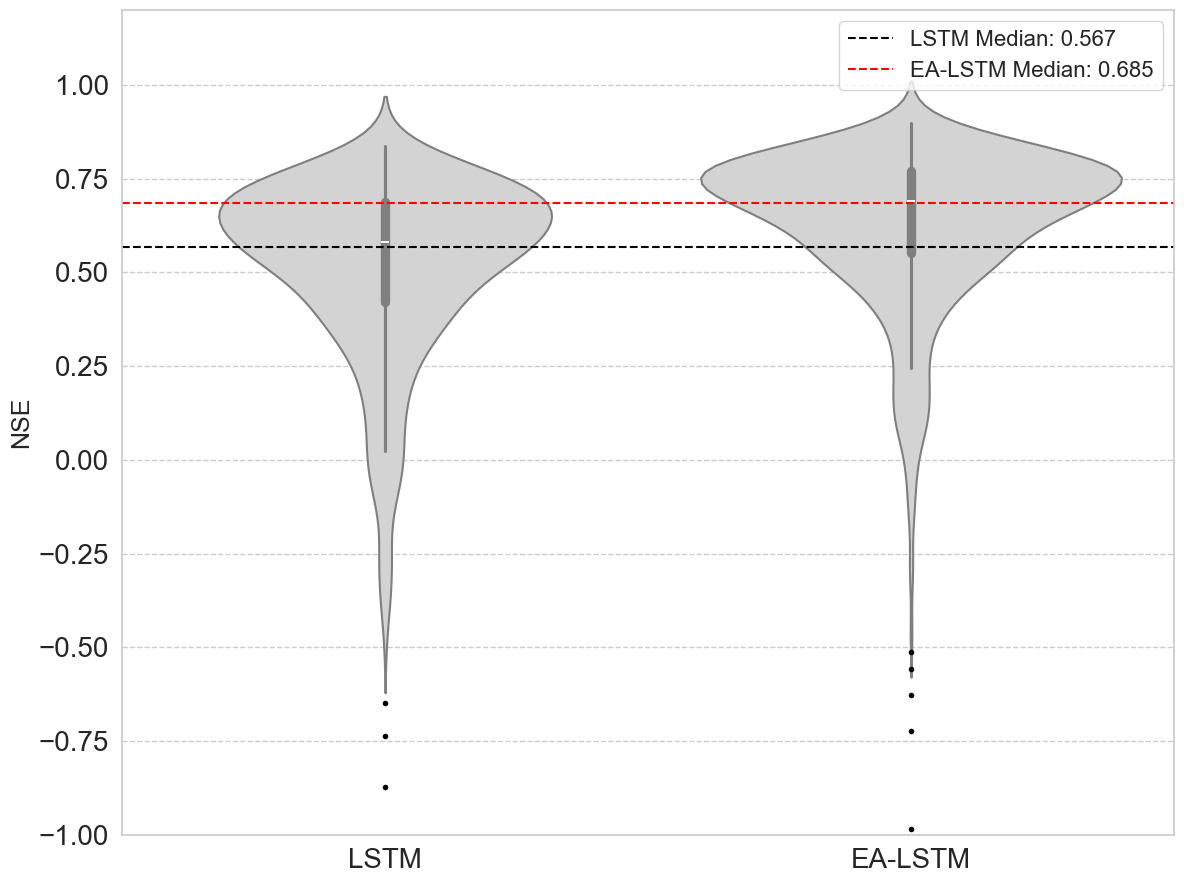

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    ea_lstm = pd.read_csv("results/EALSTM_temporal_result.csv")
    lstm = pd.read_csv("results/LSTM_temporal_result.csv")
except FileNotFoundError:
    print("CSV files not found. Generating dummy data for demonstration.")

# --- 2. Calculate Medians from the FULL Unfiltered Dataset ---
lstm_median_full = lstm['NSE'].median()
ea_lstm_median_full = ea_lstm['NSE'].median()

# --- 3. Prepare Data: Split into Violins and Outliers ---
# Add a 'Model' column to the original dataframes
lstm['Model'] = 'LSTM'
ea_lstm['Model'] = 'EA-LSTM'

# Combine into a single dataframe
combined_full_data = pd.concat([lstm, ea_lstm], ignore_index=True)

# Data for the violin plot's shape (the main distribution)
# The user's desired plot appears to show outliers below -0.5
outlier_threshold = -0.5 
data_for_violins = combined_full_data[combined_full_data['NSE'] > outlier_threshold].copy()

# Data for the outlier dots
data_for_outliers = combined_full_data[combined_full_data['NSE'] <= outlier_threshold].copy()


# --- 4. Generate the Plot Correctly ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 9))
ax = plt.gca()

# A. Draw the violin plot shape using the main distribution data
sns.violinplot(
    x='Model', y='NSE', data=data_for_violins, ax=ax,
    color="lightgray", inner="box", linewidth=1.5
)

# B. Draw the outlier dots using the outlier data
sns.stripplot(
    x='Model', y='NSE', data=data_for_outliers, ax=ax,
    color='black', size=4, jitter=False
)

# --- 5. Add Reference Lines and Customize ---
ax.axhline(y=lstm_median_full, color='black', linestyle='--', linewidth=1.5, label=f'LSTM Median: {lstm_median_full:.3f}')
ax.axhline(y=ea_lstm_median_full, color='red', linestyle='--', linewidth=1.5, label=f'EA-LSTM Median: {ea_lstm_median_full:.3f}')

# Customize labels, ticks, and grid
ax.set_ylabel('NSE', fontsize=18)
ax.set_xlabel('', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.4)
ax.xaxis.grid(False)

# Set the y-axis limits
ax.set_ylim(-1.0, 1.2)

# Set the legend to the upper right
ax.legend(fontsize=16, loc='upper right')

# --- 6. Finalize and Save ---
plt.tight_layout()
plt.savefig("nse_comparison_final_corrected.png", dpi=300)
plt.show()